导入需要的包

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import eli5
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
import shap


定义混淆矩阵绘制函数

In [8]:
def cnf_matrix_plotter(cm,classes):
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Oranges)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    threshold=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j]>threshold else "black",
                 fontsize=25)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

读取数据并过滤警告提示

In [9]:
warnings.filterwarnings("ignore")
df= pd.read_csv("process_heart1025.csv")
X=df.drop('target',axis=1)
y=df['target']
display(X)
display(y)

,age,trestbps,chol,thalach,oldpeak,ca,sex_female,sex_male,cp_asymptomatic,cp_atypical angina,...,restecg_normal,exang_no,exang_yes,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect,thal_unknown
0,52,125,212,168,1.0,2,False,True,False,False,...,False,True,False,True,False,False,False,False,True,False
1,53,140,203,155,3.1,0,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False
2,70,145,174,125,2.6,0,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
3,61,148,203,161,0.0,1,False,True,False,False,...,False,True,False,True,False,False,False,False,True,False
4,62,138,294,106,1.9,3,True,False,False,False,...,False,True,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,68,120,211,115,1.5,0,True,False,False,False,...,True,True,False,False,True,False,True,False,False,False
298,44,108,141,175,0.6,0,True,False,False,False,...,False,True,False,False,True,False,True,False,False,False
299,52,128,255,161,0.0,1,False,True,False,False,...,False,False,True,True,False,False,False,False,True,False
300,59,160,273,125,0.0,0,False,True,True,False,...,True,True,False,True,False,False,True,False,False,False


0      0
1      0
2      0
3      0
4      0
      ..
297    1
298    1
299    0
300    0
301    0
Name: target, Length: 302, dtype: int64

构建随机森林模型，其中设置最大深度为5，弱分类器数量为100，随机扰动状态设定为5（为了使每次生成的森林均不相同）

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10);
RandomForestClassifier
model=RandomForestClassifier(max_depth=5,n_estimators=100,random_state=5)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, random_state=5)

挑选随机森林中的索引为7决策树进行可视化操作

In [11]:
feature_names=X_train.columns
estimator=model.estimators_[7]
display(estimator)
#将特征值转换为字符串
y_train_str=y_train.astype('str')
y_train_str[y_train_str=='0']='no disease'
y_train_str[y_train_str=='1']='disease'
y_train_str=y_train_str.values
export_graphviz(estimator,out_file='tree.dot',feature_names=feature_names,class_names=y_train_str,rounded=True,proportion=True,label='root',precision=2,filled=True)

DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                       random_state=2059200585)

In [12]:
#call(['dot','-Tpng','tree.dot','-o','tree.png'])   该命令需要在anaconda prompt中执行

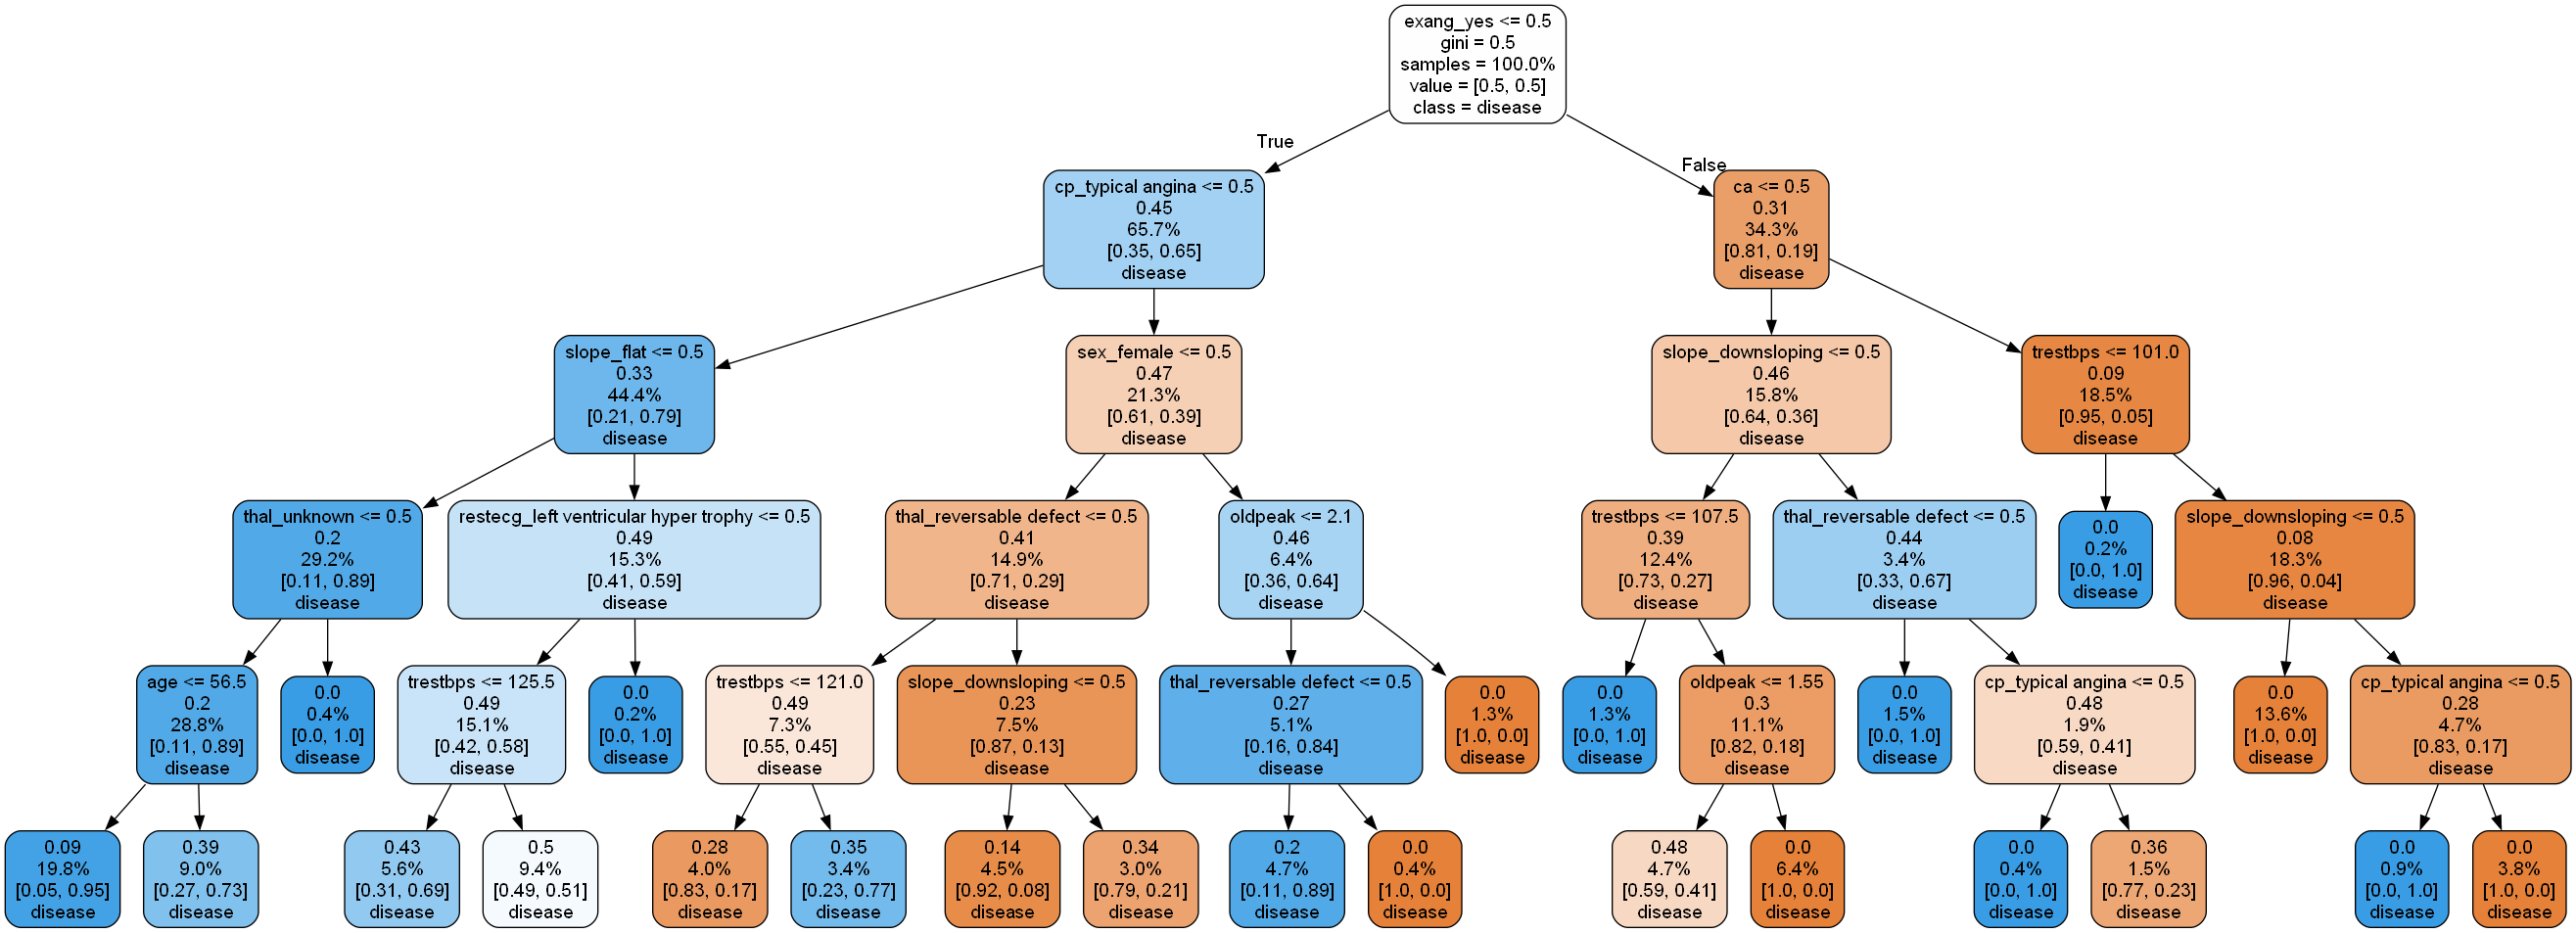

导入eli5包绘制各指标权重图

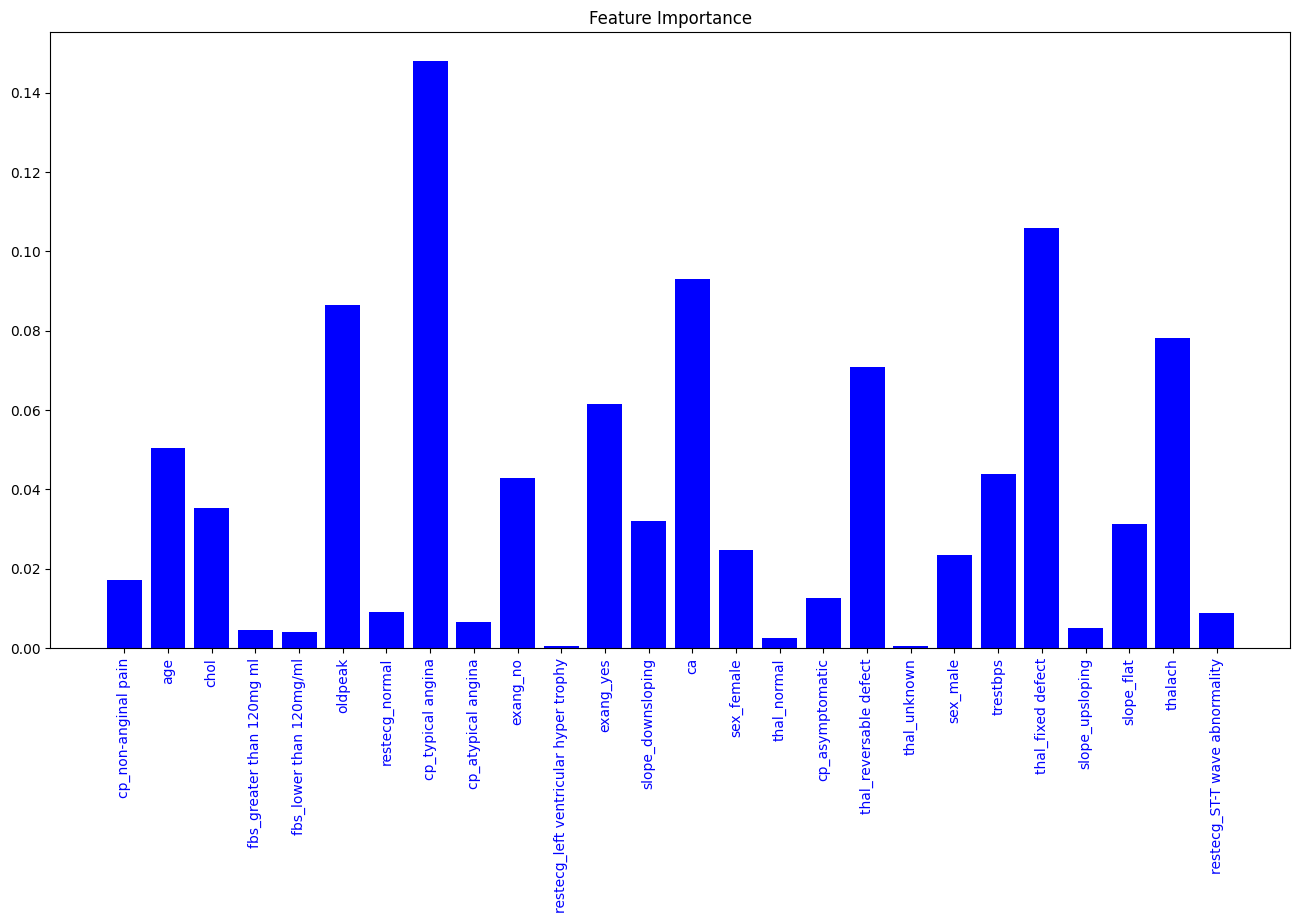

In [13]:
eli5.show_weights(estimator,feature_names=feature_names.tolist())
feature_importances=model.feature_importances_
indices=np.argsort(feature_importances[::-1])
plt.figure(figsize=(16,8))
plt.title('Feature Importance')
plt.bar(range(len(feature_importances)),feature_importances[indices],color='b')
plt.xticks(range(len(feature_importances)),np.array(feature_names)[indices],color='b',rotation=90)
plt.show()

绘制混淆矩阵以及ROC值

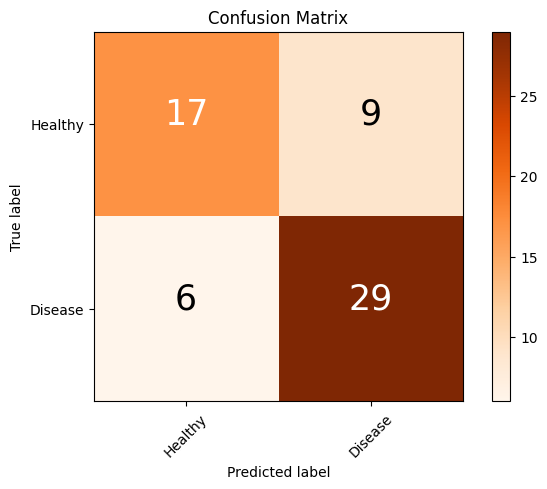

              precision    recall  f1-score   support

     Healthy       0.74      0.65      0.69        26
     Disease       0.76      0.83      0.79        35

    accuracy                           0.75        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.75      0.75        61



In [14]:
test_sample=X_test.iloc[2]
test_sample=np.array(test_sample).reshape(1,-1)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)
confusion_matrix_model=confusion_matrix(y_test,y_pred)
cnf_matrix_plotter(confusion_matrix_model, ['Healthy','Disease'])
print(classification_report(y_test, y_pred,target_names=['Healthy','Disease']))
y_pred_quant=model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds=roc_curve(y_test, y_pred_quant)

绘制ROC曲线

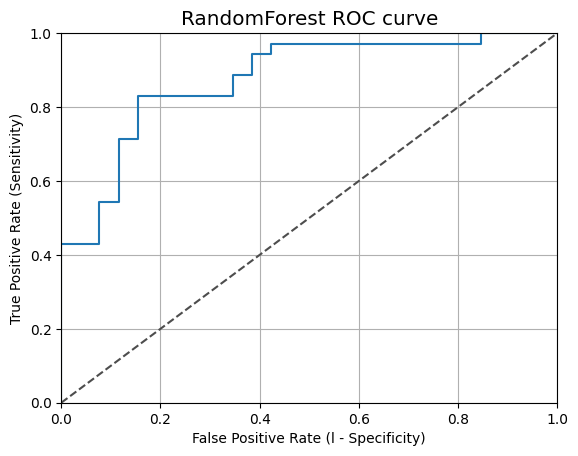

In [15]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],ls="--",c=".3")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.rcParams['font.size'] = 12
plt.title('RandomForest ROC curve')
plt.xlabel('False Positive Rate (l - Specificity)')
plt.ylabel( 'True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

In [16]:
shap.initjs()
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values[1],X_test)
shap.summary_plot(shap_values[1],X_test,plot_type="violin")
shap_interaction_values=explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values[1],X_test)

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
#选取测试集中编号为126的病人
idx=126
patient=X.iloc[idx,:]
shap_values_patient=explainer.shap_values(patient)
#展示了某个病人从测试集平均结果到最终预测结果的决策过程，以及各特征对预测结果的贡献影响
shap.force_plot(explainer.expected_value[1],shap_values_patient[1],patient)

In [ ]:
#再选取测试集中编号为166的病人（不患病）
idx=166
patient=X.iloc[idx,:]
shap_values_patient=explainer.shap_values(patient)
#展示了某个病人从测试集平均结果到最终预测结果的决策过程，以及各特征对预测结果的贡献影响
shap.force_plot(explainer.expected_value[1],shap_values_patient[1],patient)